In [213]:
import jax.numpy as jnp
from jax import random, vmap
import matplotlib.pyplot as plt

In [2]:
key = random.PRNGKey(0)

# Without Shrinkage

In [3]:
nrep = 1000
out = []

for h in [5, 50, 1000, 100000]:
    key, subkey = random.split(key)
    m = random.gamma(subkey, 1, shape=(nrep, h))
    key, subkey = random.split(key)
    lambdas = random.gamma(subkey, 1, shape=(nrep, 2, h))
    num = vmap(jnp.dot)(lambdas[:, 0, :], m)
    den = vmap(jnp.dot)(lambdas[:, 1, :], m)
    out.append(num/den)

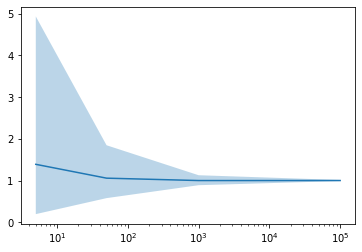

In [4]:
import matplotlib.pyplot as plt

out_iid = jnp.array(out)

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_iid, 0.025, axis=1), 
                 jnp.quantile(out_iid, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_iid, axis=1))
plt.xscale("log")
plt.yscale("log")

plt.savefig("images/ratio_iid.pdf")

In [ ]:
out_iid = jnp.array(out)

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_iid, 0.025, axis=1), 
                 jnp.quantile(out_iid, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_iid, axis=1))
plt.xscale("log")

plt.savefig("images/ratio_iid_exp.pdf")

In [5]:
def simulate_mgp(h, key):
    key, subkey = random.split(key)
    tmp = random.gamma(subkey, 2, shape=(nrep, 2, h-1))
    key, subkey = random.split(key)
    last_col = random.gamma(subkey, 1, shape=(nrep, 2, 1)) 
    tmp = jnp.concatenate([tmp, last_col], axis=-1)
    out = 1.0 / jnp.cumprod(tmp, axis=1)
    return out, key

In [6]:
nrep = 1000
out = []

for h in [5, 50, 1000, 100000]:
    key, subkey = random.split(key)
    m = random.gamma(subkey, 1, shape=(nrep, h))
    lambdas, key = simulate_mgp(h, key)
    num = vmap(jnp.dot)(lambdas[:, 0, :], m)
    den = vmap(jnp.dot)(lambdas[:, 1, :], m)
    out.append(num/den)

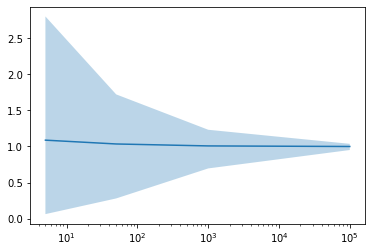

In [7]:
out_mgp = jnp.log(jnp.array(out))

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_mgp, 0.025, axis=1), 
                 jnp.quantile(out_mgp, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_mgp, axis=1))
plt.xscale("log")

plt.savefig("images/ratio_mgp.pdf")

In [ ]:
out_mgp = jnp.array(out)

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_mgp, 0.025, axis=1), 
                 jnp.quantile(out_mgp, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_mgp, axis=1))
plt.xscale("log")

plt.savefig("images/ratio_mgp_exp.pdf")

In [8]:
from jax.scipy.stats import gamma

def simulate_cusp(h, key):
    key, subkey = random.split(key)
    vs = random.beta(key, 1, 2, shape=(nrep, 2, h))
    cumprods = jnp.concatenate([
        jnp.ones(shape=(nrep, 2, 1)), 
        jnp.cumprod(1 - vs[:, :, :-1], axis=-1)], axis=-1)
    omegas = vs * cumprods
    pis = jnp.cumsum(omegas, axis=-1)
    
    key, subkey = random.split(key)
    berns = random.bernoulli(key, p=pis)
    
    key, subkey = random.split(key)
    inv_gams = 1.0 / random.gamma(key, 1.0, shape=(nrep, 2, h))
    
    out = (1-berns) * inv_gams + berns * 0.001
    
    return out, key

In [15]:
nrep = 1000
out = []

for h in [5, 50, 1000, 100000]:
    key, subkey = random.split(key)
    m = random.gamma(subkey, 1, shape=(nrep, h))
    lambdas, key = simulate_cusp(h, key)
    num = vmap(jnp.dot)(lambdas[:, 0, :], m)
    den = vmap(jnp.dot)(lambdas[:, 1, :], m)
    out.append(num / den)

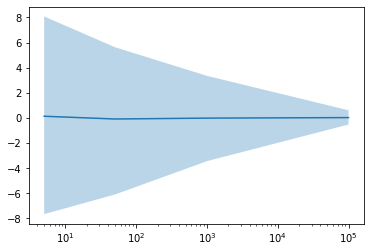

In [18]:
out_cusp = jnp.log(jnp.array(out))

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_cusp, 0.025, axis=1), 
                 jnp.quantile(out_cusp, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_cusp, axis=1))
plt.xscale("log")
plt.savefig("images/ratio_cusp.pdf")

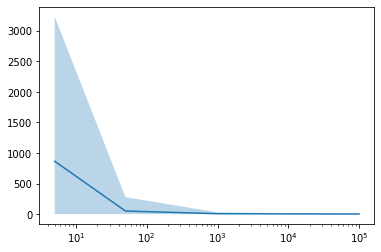

In [19]:
out_cusp = jnp.array(out)

plt.fill_between([5, 50, 1000, 100000], 
                 jnp.quantile(out_cusp, 0.025, axis=1), 
                 jnp.quantile(out_cusp, 0.975, axis=1), alpha=0.3)
plt.plot([5, 50, 1000, 100000], jnp.mean(out_cusp, axis=1))
plt.xscale("log")
plt.savefig("images/ratio_cusp_exp.pdf")

# As a function of the variance of $\Lambda$

In [26]:
nrep = 1000
out = []

h = 10

var = [0.5, 1.0, 2.0, 5.0]
for v in var:
    scale = v
    shape = 1.0 / v
    print(shape, scale)
    

    key, subkey = random.split(key)
    m = random.gamma(subkey, 1, shape=(nrep, h))
    
    key, subkey = random.split(key)
    lambdas = scale * random.gamma(subkey, shape, shape=(nrep, 2, h))
    
    num = vmap(jnp.dot)(lambdas[:, 0, :], m)
    den = vmap(jnp.dot)(lambdas[:, 1, :], m)
    
    out.append(num/den)

2.0 0.5
1.0 1.0
0.5 2.0
0.2 5.0


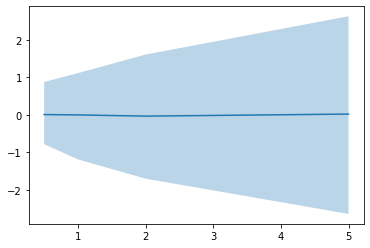

In [27]:
out_var = jnp.log(jnp.array(out))

plt.fill_between(var, 
                 jnp.quantile(out_var, 0.025, axis=1), 
                 jnp.quantile(out_var, 0.975, axis=1), alpha=0.3)
plt.plot(var, jnp.mean(out_var, axis=1))
plt.savefig("images/ratio_variance.pdf")

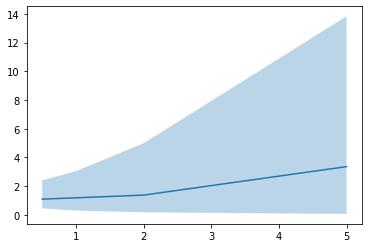

In [28]:
out_var = jnp.array(out)

plt.fill_between(var, 
                 jnp.quantile(out_var, 0.025, axis=1), 
                 jnp.quantile(out_var, 0.975, axis=1), alpha=0.3)
plt.plot(var, jnp.mean(out_var, axis=1))
plt.savefig("images/ratio_variance_exp.pdf")

# Correlation Simulation

In [3]:
from scipy.special import beta

In [160]:
def first_term_cov(ma2, ma, ca, H, a1, a2, nu):
    hrange = np.arange(1, H+1)
    return ma2 * np.sum((a2 - 1)**(-hrange + 1) * (a2 - 2)**(-hrange + 1)) / \
         (a1 - 1) / (a1 - 2) * (nu / (nu - 2))**2


def first_term_var(ma2, ma, ca, H, a1, a2, nu):
    hrange = np.arange(1, H+1)
    out = ma2 * np.sum((a2 - 1)**(-hrange + 1) * (a2 - 2)**(-hrange + 1))
    out = out * nu**2 /((nu - 2)*(nu - 4))
    return out / (a1 - 1) / (a1 - 2) 


def second_term(ma2, ma, ca, H, a1, a2, nu):
    out = 0
    for k in range(1, H+1):
        for h in range(1, k):
            out += (a2 - 1)**(-k+1) * (a2 - 2)**(-h + 1)

    out = 2 * out * (ca + ma**2) / (a1 - 1) / (a1 - 2) * (nu / (nu - 2))**2
    return out
    
    
def third_term(ma2, ma, ca, H, a1, a2, nu):
    out = 0
    for k in range(1, H+1):
        for h in range(1, H+1):
            out += (a2 - 1)**(-h - k +1)

    out = out * ma**2 * (a1 - 1)**(-2) * (nu / (nu - 2))**2
    return out


def cov_mgp(ma2, ma, ca, H, a1, a2, nu):
    return first_term_cov(ma2, ma, ca, H, a1, a2, nu) + \
           second_term(ma2, ma, ca, H, a1, a2, nu) - \
           third_term(ma2, ma, ca, H, a1, a2, nu)


def var_mgp(ma2, ma, ca, H, a1, a2, nu):
    return first_term_var(ma2, ma, ca, H, a1, a2, nu) + \
           second_term(ma2, ma, ca, H, a1, a2, nu) - \
           third_term(ma2, ma, ca, H, a1, a2, nu)


def corr_mgp(ma2, ma, ca, H, a1, a2, nu):
    return cov_mgp(ma2, ma, ca, H, a1, a2, nu) / var_mgp(ma2, ma, ca, H, a1, a2, nu)

In [355]:
ma = 0.9
phi = 2
mix = (ma + ma**2) * phi**2 * beta(1, phi)**2 * 3/2
ca = mix - ma**2
ma2 = ma**2 + ma
H = 10
nu = 5


corr_mgp(ma2, ma, ca, H, 2.1, 10.1, nu)

0.40555427640523467

In [405]:
a2_grid = np.linspace(2.1, 8, 100)
nu_grid = np.linspace(4.1, 10, 100)

X, Y = np.meshgrid(a2_grid, nu_grid)

H = 10
nu = 5
phi = 2

ma = 0.5
ma2 = ma**2 + ma
mix = (ma + ma**2) * phi**2 * beta(1, phi)**2 * 3/2
ca = mix - ma**2

corr1 = np.zeros((len(a2_grid), len(nu_grid)))
corr2 = np.zeros((len(a2_grid), len(nu_grid)))
corr3 = np.zeros((len(a2_grid), len(nu_grid)))

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        a2 = X[i, j]
        nu = Y[i, j]
        corr1[i, j] = corr_mgp(ma2, ma, ca, 4, 2.1, a2, nu)
        corr2[i, j] = corr_mgp(ma2, ma, ca, 8, 2.1, a2, nu)
        corr3[i, j] = corr_mgp(ma2, ma, ca, 16, 2.1, a2, nu)

In [404]:
i = 30
j = 50

print(a2_grid[i], nu_grid[j])
print(X[i, j], Y[i, j])

3.8878787878787877 7.07979797979798
5.079797979797981 5.887878787878788


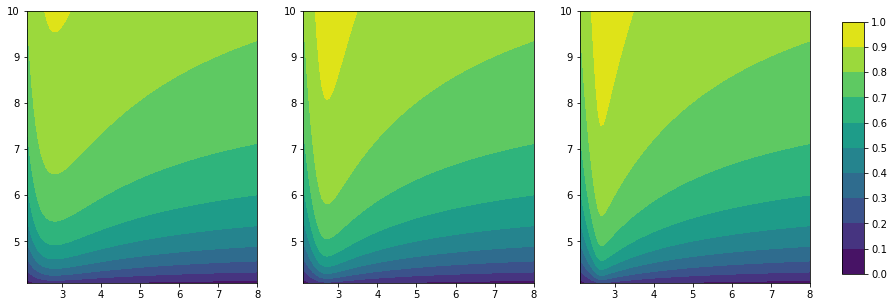

In [409]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


levels = np.linspace(0, 1, 11)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
X, Y = np.meshgrid(a2_grid, nu_grid)
axes[0].contourf(X, Y, corr1, levels=levels, vmin = 0, vmax = 1)
im = axes[1].contourf(X, Y, corr2, levels=levels, vmin = 0, vmax = 1)
im = axes[2].contourf(X, Y, corr3, levels=levels, vmin = 0, vmax = 1)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])

fig.colorbar(im, cax=cbar_ax, ticks=levels)
plt.savefig("../latex/images/corr_mgp.pdf", bbox_inches="tight")

### For the log-Gaussian process case

In [442]:
import pickle

idx1 = 249 # LA
idx2 = 248 # LA
idx3 = 106 # northern

with open("income_data/california_puma_neighbors.pickle", "rb") as fp:
    W = pickle.load(fp)

In [443]:
def cov_lgmrf(ma2, ma, ca, H, mu, sig_i, sig_j, sig_ij):
    va = (ma2 - ma**2)
    out = H * va * np.exp(2 * mu + (sig_i + sig_j) / 2 + sig_ij)
    out += H * (H - 1) * ca *np.exp(2 * mu + (sig_i + sig_j) / 2)
    out += H * ma2 * np.exp(2 * mu + (sig_i + sig_j) / 2) * (np.exp(sig_ij) - 1)
    return out


def var_lgmrf(ma2, ma, ca, H, mu, sig):
    va = (ma2 - ma**2)
    out = H * va * np.exp(2 * mu + 2 * sig)
    out += H * (H - 1) * ca * np.exp(2 * mu + sig)
    out += H * ma2 * np.exp(2 * mu + sig) * (np.exp(sig) - 1)
    return out


def corr_lgmrf(ma2, ma, ca, H, mu, sig_i, sig_j, sig_ij):
    out = cov_lgmrf(ma2, ma, ca, H, mu, sig_i, sig_j, sig_ij) 
    v1 = var_lgmrf(ma2, ma, ca, H, mu, sig_i)
    v2 = var_lgmrf(ma2, ma, ca, H, mu, sig_j)
    out = out / np.sqrt(v1 * v2)
    return out

In [506]:
phi = 3
ma = 0.5
ma2 = ma**2 + ma
mix = (ma + ma**2) * phi**2 * beta(1, phi)**2 * 3/2
ca = mix - ma**2
ca

0.875

In [508]:
phi**2 * beta(1, phi)**2

1.0

In [463]:
rho_grid = np.linspace(0.0, 0.99, 100)
tau_grid = np.linspace(0.1, 5, 100)

X, Y = np.meshgrid(rho_grid, tau_grid)

corr1_12 = np.zeros((len(rho_grid), len(tau_grid)))
corr2_12 = np.zeros((len(rho_grid), len(tau_grid)))
corr3_12 = np.zeros((len(rho_grid), len(tau_grid)))

corr1_13 = np.zeros((len(rho_grid), len(tau_grid)))
corr2_13 = np.zeros((len(rho_grid), len(tau_grid)))
corr3_13 = np.zeros((len(rho_grid), len(tau_grid)))


phi = 2
ma = 0.5
ma2 = ma**2 + ma
mix = (ma + ma**2) * phi**2 * beta(1, phi)**2 * 3/2
ca = mix - ma**2

base_var = np.eye(3)
idx1 = 0
idx2 = 1
idx3 = 2

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        rho = X[i, j]
        tau = Y[i, j]
        base_var[0, 1] = rho
        base_var[1, 0] = rho
        var = base_var / tau    
        
        corr1_12[i, j] = corr_lgmrf(
            ma2, ma, ca, 4, -np.log(4), var[idx1, idx1], var[idx2, idx2], var[idx1, idx2])
        corr2_12[i, j] = corr_lgmrf(
            ma2, ma, ca, 8, -np.log(8), var[idx1, idx1], var[idx2, idx2], var[idx1, idx2])
        corr3_12[i, j] = corr_lgmrf(
            ma2, ma, ca, 16, -np.log(16), var[idx1, idx1], var[idx2, idx2], var[idx1, idx2])
        
        corr1_13[i, j] = corr_lgmrf(
            ma2, ma, ca, 4, -np.log(4), var[idx1, idx1], var[idx3, idx3], var[idx1, idx3])
        corr2_13[i, j] = corr_lgmrf(
            ma2, ma, ca, 8, -np.log(8), var[idx1, idx1], var[idx3, idx3], var[idx1, idx3])
        corr3_13[i, j] = corr_lgmrf(
            ma2, ma, ca, 16, -np.log(16), var[idx1, idx1], var[idx3, idx3], var[idx1, idx3])

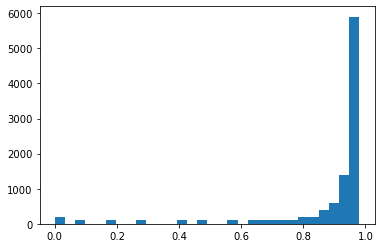

In [495]:
levels = np.concatenate([[0], plt.hist(np.ravel(corr3_13), bins="scott")[1], [1]])

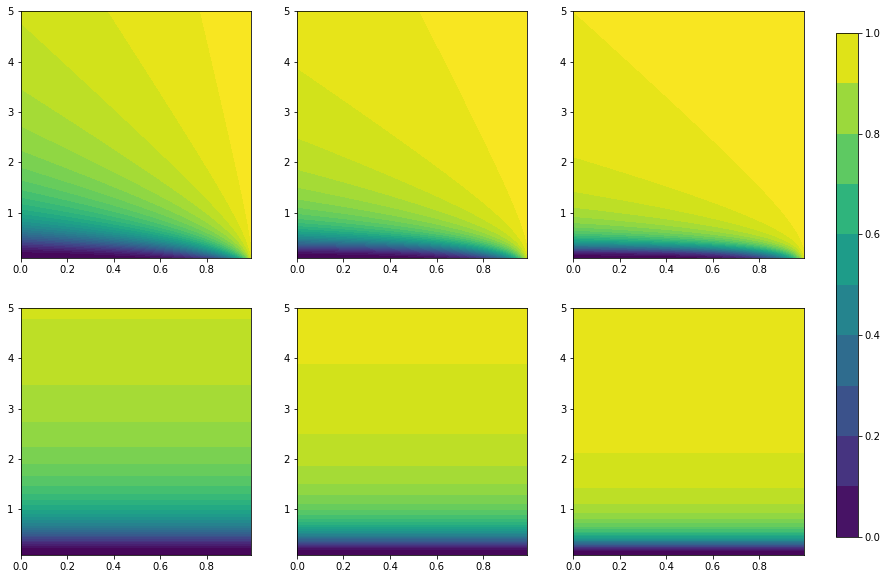

In [496]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
X, Y = np.meshgrid(rho_grid, tau_grid)

axes[0, 0].contourf(X, Y, corr1_12, levels=levels, vmin = 0, vmax = 1)
axes[0, 1].contourf(X, Y, corr2_12, levels=levels, vmin = 0, vmax = 1)
axes[0, 2].contourf(X, Y, corr3_12, levels=levels, vmin = 0, vmax = 1)

axes[1, 0].contourf(X, Y, corr1_13, levels=levels, vmin = 0, vmax = 1)
axes[1, 1].contourf(X, Y, corr2_13, levels=levels, vmin = 0, vmax = 1)
axes[1, 2].contourf(X, Y, corr3_13, levels=levels, vmin = 0, vmax = 1)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])

fig.colorbar(im, cax=cbar_ax)

plt.savefig("../latex/images/corr_lgmrf.pdf", bbox_inches="tight")